In [2]:
import numpy as np
import tensorflow as tf
import keras
import numpy as np
import os
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import utils
import AAPutils
import pandas as pd
from sklearn import model_selection, metrics, preprocessing
from sklearn.compose import ColumnTransformer
# plt.rcParams['figure.figsize'] = [8.0, 6.0]

In [10]:
df = pd.read_csv('./datasets/ecoli.csv')
df['Class'] = df['Class'].astype('category')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Mcg,336.0,0.500060,0.194634,0.00,0.34,0.500,0.6625,0.89
Gvh,336.0,0.500000,0.148157,0.16,0.40,0.470,0.5700,1.00
Lip,336.0,0.495476,0.088495,0.48,0.48,0.480,0.4800,1.00
Chg,336.0,0.501488,0.027277,0.50,0.50,0.500,0.5000,1.00
Aac,336.0,0.500030,0.122376,0.00,0.42,0.495,0.5700,0.88
Alm1,336.0,0.500179,0.215751,0.03,0.33,0.455,0.7100,1.00
Alm2,336.0,0.499732,0.209411,0.00,0.35,0.430,0.7100,0.99


In [11]:
df.Class.value_counts().to_frame()

,Class
0.0,316
1.0,20


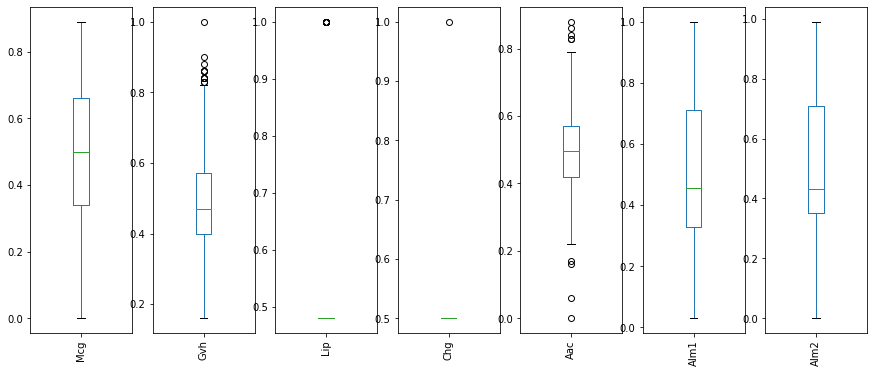

In [12]:
_ = df.plot.box(subplots=True, rot=90, figsize=(15,6))

In [164]:
X = df.loc[:,~df.columns.isin(['Class'])].values
y = preprocessing.LabelEncoder().fit_transform(df['Class'].values)

In [141]:
# solo ejecutar cuando se quiere normalizar
ct = ColumnTransformer([
    ("stand0", preprocessing.StandardScaler(), [0]),
    ("stand1", preprocessing.StandardScaler(), [1]),
    ("stand2", preprocessing.StandardScaler(), [2]),
    ("stand3", preprocessing.StandardScaler(), [3]),
    ("stand4", preprocessing.StandardScaler(), [4]),
    ("stand5", preprocessing.StandardScaler(), [5]),
    ("stand6", preprocessing.StandardScaler(), [6]),
])

X = ct.fit_transform(X)

In [165]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=7, stratify = y)

In [166]:
d_in = X.shape[1]
d_out = np.unique(y).size
classes = d_out

In [167]:
# verificamos los valores
d_in, d_out, X_train.shape, y_train.shape, X_test.shape, y_test.shape,

(7, 2, (235, 7), (235,), (101, 7), (101,))

In [168]:
# y_test.reshape(-1,1)
utils.calculate_class_weight(y_train), utils.calculate_class_weight(y_test), 

({0: 0.9404255319148936, 1: 0.059574468085106386},
 {0: 0.9405940594059405, 1: 0.0594059405940594})

In [169]:
weight = {
   0: 0.8, 1: 0.2
}

In [170]:
layers = []

layer1 = keras.layers.Dense(
    100, 
    input_shape=(d_in,), 
    activation='relu'
)
layers.append(layer1)


layer2 = keras.layers.Dense(
    100, 
    activation='relu'
)
layers.append(layer2)


# layers.append(
#     keras.layers.Dense(
#     60, 
#     activation='relu'
# ))

# layers.append(keras.layers.Dense(
#     10, 
#     activation='relu'
# ))

# layers.append(keras.layers.Dense(
#     10, 
#     activation='relu'
# ))


# https://en.wikipedia.org/wiki/Logit
# la ultima capa si o si tiene que tener tantas salidas como clases, y softmax 
output = keras.layers.Dense(classes, activation='softmax')
layers.append(output)

# Creo un modelo logístico
model = keras.Sequential()

for l in layers:
    model.add(l)

# posibles optimizadores:
# https://keras.io/optimizers/

alpha = 0.001
epochs = 1500

model.compile(
  optimizer= 'adam',
  #optimizer = keras.optimizers.SGD(lr=alpha), 
  loss='sparse_categorical_crossentropy', # error para ir calculando en cada iteracion o batch 
  # Agregamos el accuracy del modelo
  metrics=[
      'accuracy', 
      #'sparse_categorical_accuracy'
  ], 
)

In [1]:
# Entrenamiento del modelo
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=32, 
    verbose=0, 
#     initial_epoch=400,
    callbacks = [
        # https://stackoverflow.com/questions/43906048/keras-early-stopping
        # https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
        # Early stopping callback is called on every epoch end, compares the best monitored value with the current one and stops if conditions are met
       keras.callbacks.callbacks.EarlyStopping(
           monitor='val_loss', 
#            min_delta=0, 
           patience=50,
           verbose=0, 
           mode='auto', 
#            baseline=0.3, 
           restore_best_weights=True
       )
    ],
    validation_data = (X_test, y_test),
    class_weight = weight # acá va esto? o el de train?
)
model.summary()

NameError: name 'model' is not defined

In [172]:
print(10*"=")
print("TEST SCORES")
print(metrics.classification_report(y_test, model.predict_classes(X_test)))
print(model.metrics_names)
print(model.evaluate(X_test, y_test))
print(10*"=")
print("TRAIN SCORES")
print(metrics.classification_report(y_train, model.predict_classes(X_train)))
print(model.metrics_names)
print(model.evaluate(X_train, y_train))

TEST SCORES
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        95
           1       1.00      0.83      0.91         6

    accuracy                           0.99       101
   macro avg       0.99      0.92      0.95       101
weighted avg       0.99      0.99      0.99       101

['loss', 'accuracy']
101/101 [==============================] - 0s 46us/step
[0.07338667520792178, 0.9900990128517151]
TRAIN SCORES
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       221
           1       1.00      0.86      0.92        14

    accuracy                           0.99       235
   macro avg       1.00      0.93      0.96       235
weighted avg       0.99      0.99      0.99       235

['loss', 'accuracy']
235/235 [==============================] - 0s 55us/step
[0.026917766137643063, 0.9914893507957458]


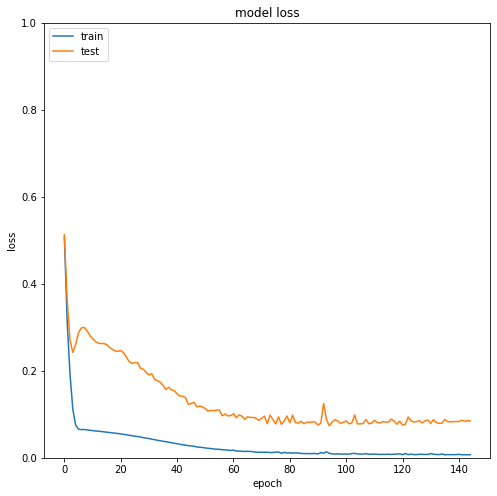

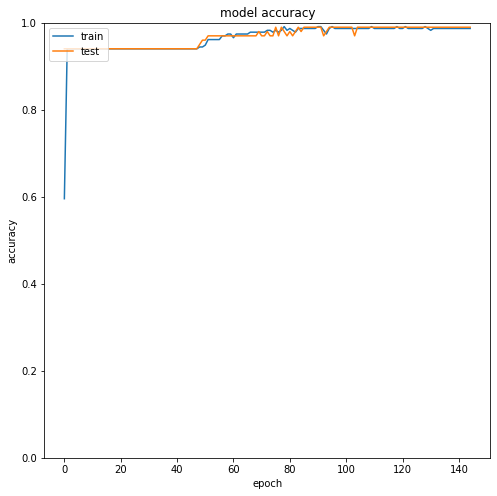

In [173]:
for k, i in zip(list(range(len(model.metrics_names))), model.metrics_names):
    plt.figure(figsize=(8,8))
    plt.ylim(0,1)
    utils.plot_curve(history, i)

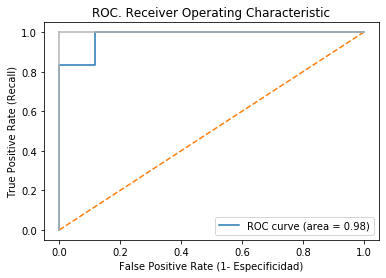

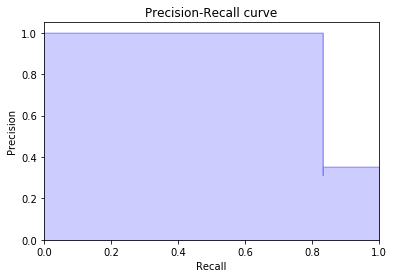

In [174]:
AAPutils.plot_ROC_curve(model, X_test, y_test)

In [163]:
print(metrics.confusion_matrix(y_test, model.predict_classes(X_test)))

[[93  2]
 [ 1  5]]


## Conclusiones
Hicimos train_test_split de manera "stratify".

___
### 1 capa

con una capa de 10 neuronas, nuestro modelo obtiene acc de .94 en testing en aprox 70 epochs.
Si vemos el F1 score, es muy bueno para 0 (.97) pero malo para 1 (0). El acc es engañoso. 
Empieza a overfittear en 10 epochs. 
El loss es prácticamente el mismo ara los dos: 
```TEST f1: {1:0 0:.97}, ROC: 0.06 (malisimo), acc: .94, weight: { 0: 0.95, 1: 0.05 },```

Cambiando el peso, parece que las métricas mejoraron
```TEST f1: {1:0 0:.97}, ROC: 0.37 (malisimo), acc: .94, weight: { 0: 0.8, 1: 0.2 },```

Con una capa de 100 neuronas, empieza a overfittear en 120 epochs. Mejora el acc en test: 0.98. Empezó a detectar ejemplos de la clase 1. ROC mejoró
```TEST f1: {1:0.83 0:.92}, ROC: 0.97 (malisimo), acc: .94, weight: { 0: 0.8, 1: 0.2 },```
- 0       0.99      0.99      0.99        95
- 1       0.83      0.83      0.83         6
Si vemos la precision y recall es la misma.  Alteramos los pesos.  ```weight: { 0: 0.6, 1: 0.4 },```
- 0       0.99      0.98      0.98        95
- 1       0.71      0.83      0.77         6
Parece que el anterior peso es mejor . Si ponemos el que corresponde (0.9-0.1) no detecta casos de 1. 


Con una segunda capa de 50 neuronas, mejoraron las detecciónes de 1. En 60 aprox comienza a overfittear.
El acc es de 0.99, ROC 0.97. El f1 en 1 mejoró mucho.
- 0       0.99      1.00      0.99        95
- 1       1.00      0.83      0.91         6

Con una capa de 100 neuronas, no tuvo mejoras. Parece que el modelo llegó a su tope.
 - 0       0.99      1.00      0.99        95
 - 1       1.00      0.83      0.91         6
Incluso, agregando otra capa obtenemos los mismos resultados. 

Si realizamos normalizamos los datos (StandardScaler), empeora nuestra precisión.
- 0       0.99      0.98      0.98        95
- 1       0.71      0.83      0.77         6